### 0. Система и среда выполнения кода

###### OS Name: 'Microsoft Windows 7 64'
###### OS Version: 6.1.7601 7601
###### CPU: Intel(R) Core(TM) i5-4300M CPU @ 2.60GHz
###### RAM: 7.907649993896484 GB
###### Graphics Card: Intel(R) HD Graphics 4600 /n

#### *** Внимание! Этот ноутбук выполняется на PC с вышеуказанными параметрами около 3 часов.

Можно сразу перейти к результатам работы.

Для этого необходимо:
    
1. Скачать полученные в ходе работы этого ноутбука файлы по ссылке: 
    
https://drive.google.com/file/d/1NKYEAx9B5YgfHKrbT-ndTxQPgQJpYQTl/view?usp=sharing
    
2. Распаковать в любой  каталог. Указать этот каталог в переменной 'DATA_PATH' (в параграфе с imports)

3. Запустить параграф с imports и параграф с функцией get_answer()


!!! При 'честном' запуске ноутбука следующие файлы должны находиться в каталоге с именем содержащемся в 'DATA_PATH' :
1. 'ProductsDataset.csv'
2. 'Otvety.txt'
3. 'prepared_answers.txt' (должен быть заранее подготовлен или же потребуется запустить код для его получения в пункте 1.1)


In [22]:
!pip freeze

acapture==1.2.6
aiohttp==3.8.0
aiosignal==1.2.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
annoy==1.17.0
app==0.0.1
appdirs==1.4.4
argh==0.26.2
asn1crypto==1.3.0
astroid==2.3.3
astropy==4.0
astunparse==1.6.3
async-generator==1.10
async-timeout==4.0.1
asynctest==0.13.0
atomicwrites==1.3.0
attrs==19.3.0
autopep8==1.4.4
Babel==2.8.0
backcall==0.1.0
backports.functools-lru-cache==1.6.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
bcrypt==3.1.7
beautifulsoup4==4.8.2
bitarray==1.2.1
bkcharts==0.2
bleach==3.1.0
blinker==1.4
bokeh==1.4.0
boto==2.49.0
Bottleneck==1.3.2
browser-cookie3==0.11.4
bs4==0.0.1
cachetools==4.2.2
catboost==0.24.4
certifi==2020.12.5
cffi==1.14.0
chardet==3.0.4
charset-normalizer==2.0.7
Click==7.0
cloudpickle==1.3.0
clyent==1.2.2
colorama==0.4.3
colorlover==0.3.0
colour==0.1.5
comtypes==1.1.7
conda==4.8.5
conda-build==3.18.11
conda-package-handling==1.6.0
conda-verify==3.4.2

In [23]:
from tqdm.notebook import tqdm
import time
import string
import os
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import codecs
import pickle
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
import annoy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

DATA_PATH = 'e:/ML14/DN/chatbot_files/'

tqdm.pandas()  # enable 'progress_apply' function

tbeg = time.perf_counter()

### 1. Обучение классификатора продуктовых запросов

 Создаем датасет 'table' для классификатора. Он состоит из двух датасетов - один (df_products) с текстом содержащим описания или названия продуктов и размеченный как True, а другой (df_questions), содержащий вопросы из болталки и размеченный как False.

\* чтобы не повторять при отладке длительные процедуры кода - промежуточные результаты сохранялись в файлы, а код в ноутбке сохранялся как NBCcontent

#### 1.1 Создание датасета

In [24]:
# Так как строки иногда разрываются (по символу \n) не после последнего поля), то приходится
# преобразовать файл 'ProductsDataset.csv' так, чтобы строка заканчивалась после последовательности ".jpg"
# В итоге получаем новый файл 'prodDS.csv'.


out_line = ''
c = 0
with codecs.open(DATA_PATH + "prodDS.csv", "w", "utf_8_sig") as fout:
    with codecs.open(DATA_PATH + "ProductsDataset.csv", "r", "utf_8_sig") as fin:
        for line in tqdm(fin):
            c += 1
            # print(c)
            # if c>10:
            #   break
            if c > 1:
                if line.endswith(".jpg\n") != True:
                    # print('No')
                    # print(line)
                    not_EOL = True
                    out_line = (out_line+line).replace('\n', ' ')
                    continue
                else:
                    # print('Yes')
                    out_line = out_line+line
                    # print(out_line)
                    fout.write(out_line)
                    not_EOL = False
                    out_line = ''
            else:
                fout.write(line)

0it [00:00, ?it/s]

In [25]:
df = pd.read_csv(DATA_PATH + "prodDS.csv")
df = df.fillna('')
df['label'] = 0  # Добавим разметку
df.columns = ['title', 'description', 'product_id', 'category_id', 'subcategory_id',
              'properties', 'image_links', 'label']  # исправим 'descrirption' -> 'description'

In [26]:
# Объединим названия и описания в один текстовый столбец так, как:
# "...продуктовым можно считать запрос, который равен названию или описанию товара" .

df1 = df[['description', 'label']]
df2 = df[['title', 'label']]
df1.columns = ['text', 'label']
df2.columns = ['text', 'label']

df_products = pd.concat([df1, df2], ignore_index=True)

In [27]:
# Соберем датафрейм с вопросами из болталки
questions = []
with codecs.open(DATA_PATH + "prepared_answers.txt", "r", "utf_8_sig") as f:
    for line in tqdm(f):
        spls = line.split("\t")
        questions.append(spls[0])

df_questions = pd.DataFrame({'text': questions})
df_questions['label'] = 1  # Добавим разметку

0it [00:00, ?it/s]

In [28]:
# Собираем итоговый датасет
table = pd.concat([df_products, df_questions], ignore_index=True)
# Remove rows with empty text cells
table.drop(index=table[table.text == ''].index, inplace=True)
table.reset_index(drop=True, inplace=True)

In [29]:
table['text']

0          Новая, не носили ни разу. В реале красивей чем...
1          Новые,привезены из Чехии ,указан размер 40,но ...
2          Размер 40-42. Брюки почти новые - не знаю как ...
3          Продам шапки,кажда 200р.Розовая и белая проданны.
4          Темно-синяя, 42 размер,состояние отличное,как ...
                                 ...                        
1232604    Между словами ПРЕЗИДЕНТ и РЕЗИДЕНТ есть что ли...
1232605    "Если это мое, то оно никуда от меня не денетс...
1232606          А Вы халяву любите или совесть имеете???) .
1232607    Так много разных гороскопов кто-нибудь может п...
1232608    В пылу страстей она сломала мне вставную челюс...
Name: text, Length: 1232609, dtype: object

#### 1.2 Препроцессинг датасета

In [30]:
r = RussianStemmer()

sw = set(get_stop_words("ru")).union(
    set('1234567890qwertyuiopasdfghjklzxcvbnmйцукенгшщзхъфываепнроглшщджэячсмитьбю'))
exclude = set(string.punctuation)


def pprocess(line):
    line = re.sub("[\x0b\x0c\s]", ' ', line.lower())
    line = re.sub("(б\.у)|(б\/у)|(б\\у)", 'бу', line)
    line = re.sub("[^а-яё \d\w]", ' ', line)

    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [r.stem(i) for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return ' '.join(spls)

In [31]:
t = time.perf_counter()
table_processed = table['text'].progress_apply(lambda x: pprocess(x))
print('Elapsed, s:', time.perf_counter() - t)

  0%|          | 0/1232609 [00:00<?, ?it/s]

Elapsed, s: 1616.8297770210002


#### 1.3 Разбиение датасета и обучение модели

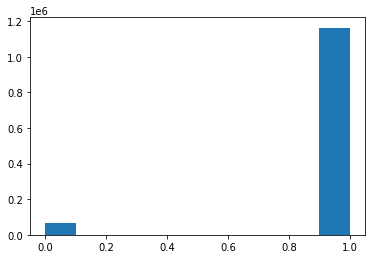

Product(69085)/Non-product(1163524) = 0.05937565533671845


In [32]:
X = table_processed.to_list()
y = table['label'].to_list()

plt.hist(y)
plt.show()
s1 = (table['label'] == 1).sum()
s0 = (table['label'] == 0).sum()
print(f'Product({s0})/Non-product({s1}) = {s0/s1}')
# Классы распределены неравномерно - будем использовать stratify при разбиении на тест и трейн

In [33]:
# Make datasets with similar classes distribution
TX_train, TX_test, ly_train, ly_test, text_train, text_test = train_test_split(
    X, y, table['text'], test_size=0.20, random_state=42, shuffle=True, stratify=y)

In [34]:
t = time.perf_counter()
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
vectorizer.fit(TX_train)
print('Elapsed, s:', time.perf_counter() - t)

Elapsed, s: 164.19502953200026


In [35]:
t = time.perf_counter()

X_train = vectorizer.transform(TX_train)
y_train = np.array(ly_train)

X_test = vectorizer.transform(TX_test)
y_test = np.array(ly_test)

print('Elapsed, s:', time.perf_counter() - t)

Elapsed, s: 68.66169596200052


In [36]:
# Посмотрим на текстовые векторы...
X_train

<986087x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 12762556 stored elements in Compressed Sparse Row format>

In [37]:
# create LinearSVM model object and fit the model
model_svm = svm.LinearSVC()
model_svm.fit(X_train, y_train)

LinearSVC()

In [38]:
# Сохраняем классификатор
with open(DATA_PATH + 'query_model_stem_tdfv_best.pickle', 'wb') as f:
    pickle.dump(model_svm, f)

In [39]:
# Посмотрим на различные рекомендуемые метрики при дисбалансе классов
predictions = model_svm.predict(X_test)
f1_s = f1_score(y_test, predictions)
f2 = fbeta_score(y_test, predictions, beta=2.0)
accuracy = (predictions == y_test).mean()
print(accuracy, f1_s, f2)

0.9947306934066736 0.9972112315021351 0.9977085896528259


confusion_matrix

TP FN

FP TN


In [40]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = predictions
cm = confusion_matrix(y_true, y_pred)
print('Всего запросов в тестовой выборке:', len(y_test))
print('Правильно классифицированных продуктовых запросов:',
      cm[0, 0], 'Ошибочно потерянных продуктовых запросов:', cm[0, 1])
print('Ошибочно принятых за продуктовые запросы:',
      cm[1, 0], 'Правильно классифицированных мусорных запросов:', cm[1, 1])
print('Процент потерянных истинных продуктовых запросов:',
      100*cm[0, 1]/cm[0, 0])
print('Процент принятых мусорных запросов:', 100*cm[1, 0]/cm[1, 1])

Всего запросов в тестовой выборке: 246522
Правильно классифицированных продуктовых запросов: 12974 Ошибочно потерянных продуктовых запросов: 843
Ошибочно принятых за продуктовые запросы: 456 Правильно классифицированных мусорных запросов: 232249
Процент потерянных истинных продуктовых запросов: 6.497610605827039
Процент принятых мусорных запросов: 0.19634099608609726


### 2. Поиск похожих товаров в контентной части бота

#### 2.1 Препроцессинг и векторизация продуктовых названий

In [41]:
sw = set(get_stop_words("ru")).union(
    set('1234567890qwertyuiopasdfghjklzxcvbnmйцукенгшщзхъфываепнроглшщджэячсмитьбю'))
exclude = set(string.punctuation)
morpher = MorphAnalyzer()


def products_preprocess_txt(line):
    line = re.sub("[\x0b\x0c\s]", ' ', line.lower())
    line = re.sub("(б\.у)|(б\/у)|(б\\у)", 'бу', line)
    line = re.sub("[^а-яё \d\w]", ' ', line)

    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [42]:
# Для обучения Word2Vec создадим датасет из названий и описаний длиной больше 20 символов.
df_products = pd.concat(
    [df1.loc[df1.text.str.len() > 20], df2], ignore_index=True)

In [43]:
t = time.perf_counter()
products_processed = df_products['text'].progress_apply(
    lambda x: products_preprocess_txt(x))
print('Elapsed, s:', time.perf_counter() - t)

  0%|          | 0/65594 [00:00<?, ?it/s]

Elapsed, s: 237.08028802599983


In [44]:
# Обучаем модель для продуктовых запросов
t = time.perf_counter()
model_w2v_products = Word2Vec(
    sentences=products_processed.to_list(), vector_size=100, min_count=1, window=5)
print('Elapsed, s:', time.perf_counter() - t)

Elapsed, s: 4.31583441300063


In [48]:
# Складываем в индекс все наши названия продуктовых запросов
t = time.perf_counter()
index = annoy.AnnoyIndex(100, 'angular')

index_map = {}
counter = 0


def annoy_indexing(row):
    global counter
    n_w2v = 0
    index_map[counter] = row['product_id'] + ' ' + row['title']
    product_query = products_preprocess_txt(row['title'])
    vector = np.zeros(100)
    for word in product_query:
        if word in model_w2v_products.wv:
            vector += model_w2v_products.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    index.add_item(counter, vector)
    counter += 1

df.apply(lambda x: annoy_indexing(x), 1)
index.build(10)

print('Elapsed, s:', time.perf_counter() - t)

Elapsed, s: 28.512096751000172


In [49]:
def find_description(product_title):
    preprocessed_title = products_preprocess_txt(product_title)
    n_w2v = 0
    vector = np.zeros(100)
    for word in preprocessed_title:
        if word in model_w2v_products.wv:
            vector += model_w2v_products.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index.get_nns_by_vector(vector, 1)
    return index_map[answer_index[0]]

In [50]:
find_description('Юбка детская ORBY')

'58e3cfe6132ca50e053f5f82 Юбка детская ORBY'

### 3. Болталка

#### 3.1 Препроцессинг и векторизация вопросов болталки

In [51]:
morpher = MorphAnalyzer()
sw = set(get_stop_words("ru"))
exclude = set(string.punctuation)


def preprocess_txt(line):
    spls = "".join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != ""]
    return spls

In [53]:
t = time.perf_counter()
sentences = []
c = 0
with codecs.open(DATA_PATH + "Otvety.txt", "r", "utf_8_sig") as fin:
    for line in tqdm(fin):
        spls = preprocess_txt(line)
        sentences.append(spls)
        c += 1
        if c > 500000:
            break

print('Elapsed, s:', time.perf_counter() - t)

0it [00:00, ?it/s]

Elapsed, s: 2758.891974395


In [54]:
sentences = [i for i in sentences if len(i) > 2]

In [55]:
# Обучим модель word2vec на наших вопросах
t = time.perf_counter()
model = Word2Vec(sentences=sentences, vector_size=100, min_count=1, window=5)

print('Elapsed, s:', time.perf_counter() - t)

Elapsed, s: 68.04693550799857


#### 3.2 Индексация вопросов

In [56]:
# Складываем в индекс все наши вопросы из болталки
t = time.perf_counter()
index_s = annoy.AnnoyIndex(100, 'angular')

index_map_s = {}
counter = 0

with codecs.open(DATA_PATH + "prepared_answers.txt", "r", "utf_8_sig") as f:

    for line in tqdm(f):
        n_w2v = 0
        spls = line.split("\t")
        if len(spls) > 1:
            index_map_s[counter] = spls[1]
            question = preprocess_txt(spls[0])
            vector = np.zeros(100)
            for word in question:
                if word in model.wv:
                    vector += model.wv[word]
                    n_w2v += 1
            if n_w2v > 0:
                vector = vector / n_w2v
            index_s.add_item(counter, vector)

        counter += 1
index_s.build(10)
print('Elapsed, s:', time.perf_counter() - t)

0it [00:00, ?it/s]

Elapsed, s: 6318.924998086


In [57]:
def find_answer(question):
    preprocessed_question = preprocess_txt(question)
    n_w2v = 0
    vector = np.zeros(100)
    for word in preprocessed_question:
        if word in model.wv:
            vector += model.wv[word]
            n_w2v += 1
    if n_w2v > 0:
        vector = vector / n_w2v
    answer_index = index_s.get_nns_by_vector(vector, 1)
    return index_map_s[answer_index[0]]

In [58]:
find_answer('Эбу в двенашке называется Итэлма что за эбу?')

'ЭБУ — электронный блок управления двигателем автомобиля, его другое название — контроллер. Он принимает информацию от многочисленных датчиков, обрабатывает ее по особым алгоритмам и, отталкиваясь от полученных данных, отдает команды исполнительным устройствам системы.. \n'

In [59]:
print('Total Run Time Elapsed, s:', time.perf_counter() - tbeg)

Total Run Time Elapsed, s: 11613.777325656


### Обертка функций и реализация чат-бота

In [ ]:
try:
    # Подгружаем ранее сохраненный и обученный векторайзер
    with open(DATA_PATH + 'TfidfVectorizer.pickle', 'rb') as f:
        vectorizer = pickle.load(f)
    # Подгружаем ранее сохраненный и обученный классификатор
    with open(DATA_PATH + 'query_model_stem_tdfv_best.pickle', 'rb') as f:
        model_svm = pickle.load(f)

    # Подгружаем предварительно обученную модель продуктовых названий
    model_w2v_products = Word2Vec.load(DATA_PATH + "w2v_model_products")

    # Подгружаем предварительно подготовленный и сохранненый индекс продуктовых названий
    with open(DATA_PATH + 'index_map_products.pickle', 'rb') as f:
        index_map = pickle.load(f)
    index = annoy.AnnoyIndex(100, 'angular')
    index.load(DATA_PATH + 'products.ann')

    # Подгружаем предварительно обученную модель вопросов из болталки
    model = Word2Vec.load(DATA_PATH + "w2v_model")

    # Подгружаем предварительно подготовленный и сохранненый индекс ответов из болталки
    with open(DATA_PATH + 'index_map_speaker.pickle', 'rb') as f:
        index_map_s = pickle.load(f)
    index_s = annoy.AnnoyIndex(100, 'angular')
    index_s.load(DATA_PATH + 'speaker.ann')
except:
    pass


r = RussianStemmer()
morpher = MorphAnalyzer()
sw_ = set(get_stop_words("ru"))
sw = sw_.union(
    set('1234567890qwertyuiopasdfghjklzxcvbnmйцукенгшщзхъфываепнроглшщджэячсмитьбю'))
exclude = set(string.punctuation)

def get_answer(text):
    
    def pprocess(line):
        # используется для обработки текстовых данных при обучении классификатора
        line = re.sub("[\x0b\x0c\s]", ' ', line.lower())
        line = re.sub("(б\.у)|(б\/у)|(б\\у)", 'бу', line)
        line = re.sub("[^а-яё \d\w]", ' ', line)
        spls = "".join(i for i in line.strip() if i not in exclude).split()
        spls = [r.stem(i) for i in spls]
        spls = [i for i in spls if i not in sw and i != ""]
        return ' '.join(spls)

    def products_preprocess_txt(line):
        # используется для обработки текстовых данных при сворачивании продуктовых названий в  Word2Vec 
        line = re.sub("[\x0b\x0c\s]", ' ', line.lower())
        line = re.sub("(б\.у)|(б\/у)|(б\\у)", 'бу', line)
        line = re.sub("[^а-яё \d\w]", ' ', line)
        spls = "".join(i for i in line.strip() if i not in exclude).split()
        spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
        spls = [i for i in spls if i not in sw and i != ""]
        return spls

    def preprocess_txt(line):
        # используется для обработки текстовых данных при сворачивании вопросов из болталки в  Word2Vec 
        spls = "".join(i for i in line.strip() if i not in exclude).split()
        spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
        spls = [i for i in spls if i not in sw_ and i != ""]
        return spls

    def find_description(product_title):
        # находит id и title входному продуктовому запросу
        preprocessed_title = products_preprocess_txt(product_title)
        n_w2v = 0
        vector = np.zeros(100)
        for word in preprocessed_title:
            if word in model_w2v_products.wv:
                vector += model_w2v_products.wv[word]
                n_w2v += 1
        if n_w2v > 0:
            vector = vector / n_w2v
        answer_index = index.get_nns_by_vector(vector, 1)
        return index_map[answer_index[0]]

    def find_answer(question):
        # находит ответ из болталки по  входному вопросу 
        preprocessed_question = preprocess_txt(question)
        n_w2v = 0
        vector = np.zeros(100)
        for word in preprocessed_question:
            if word in model.wv:
                vector += model.wv[word]
                n_w2v += 1
        if n_w2v > 0:
            vector = vector / n_w2v
        answer_index = index_s.get_nns_by_vector(vector, 1)
        return index_map_s[answer_index[0]]

    # product or speaker?
    if model_svm.predict(vectorizer.transform([pprocess(text)]))[0] == 1:
        # speaker
        return find_answer(text)
    else:
        # product
        return find_description(text)

#### Автотесты

In [ ]:
assert(get_answer('Юбка детская ORBY').startswith('58e3cfe6132ca50e053f5f82'))

In [ ]:
assert(not get_answer('Где ключи от танка').startswith('5'))